In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

In [28]:
toload = [ 
    dict(name="hiresbase", id="d34-d28a_neutbc_fixes", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="base", id="hn2d1cb-merge_master", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="main", id="hn2d7de-dirichlet_hot", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="hnthresh0_old", id="hn3b-hnthresh_0ev", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="hnthresh0", id="hn4-hnthresh_0_allfields_fixfloor", unnormalise_geom = True, use_xhermes = True, squash = False), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case d34-d28a_neutbc_fixes
-----------------------
- Looking for squash file
- Squash file found. squash date 12/12/2023, 11:28:35, dmp file date 12/11/2023, 19:20:57

Unnormalising with xHermes
- Reading case hn2d1cb-merge_master
-----------------------

Unnormalising with xHermes
- Reading case hn4-hnthresh_0_allfields_fixfloor
-----------------------

Unnormalising with xHermes


# Convergence

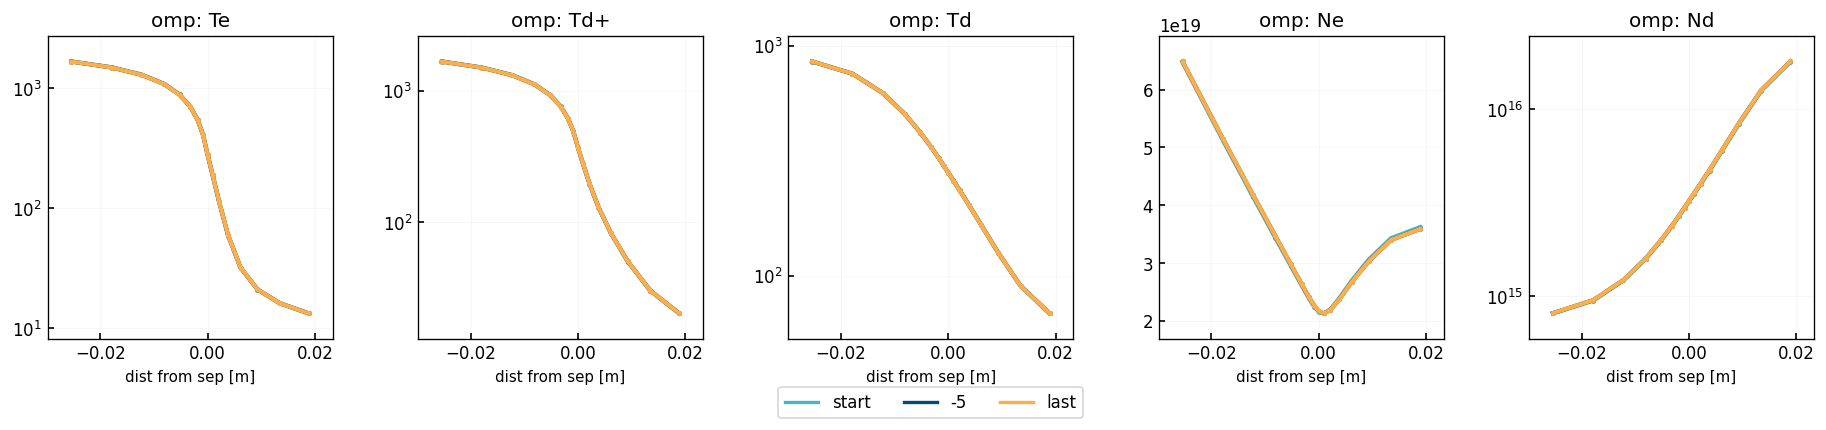

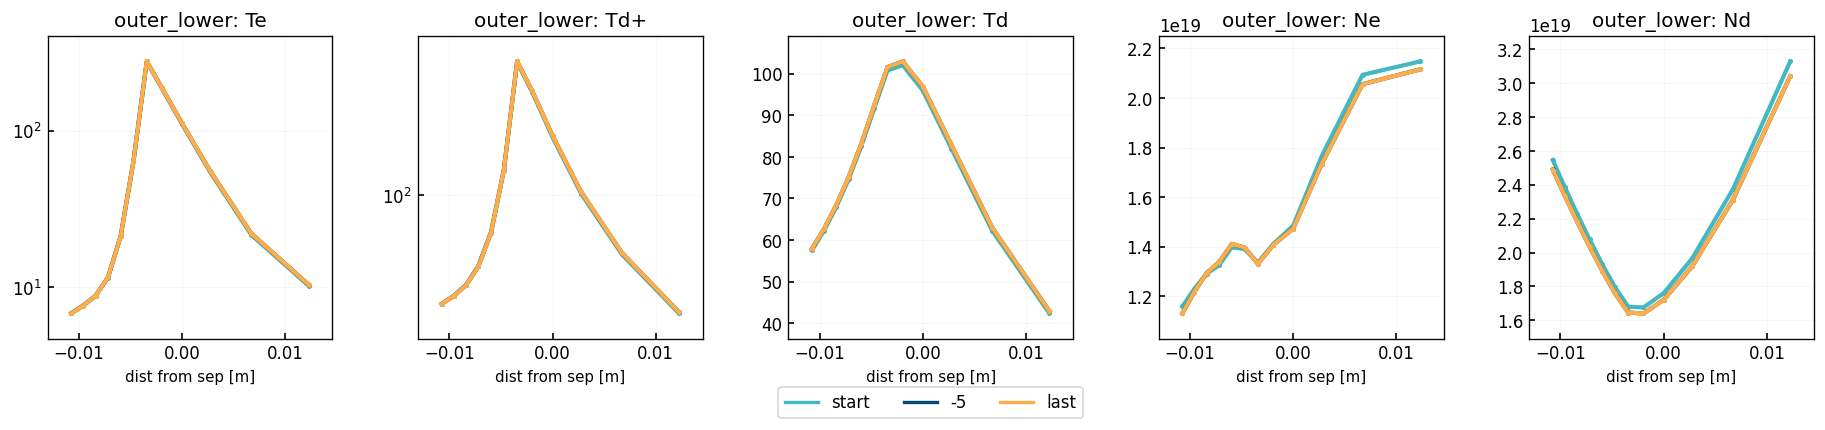

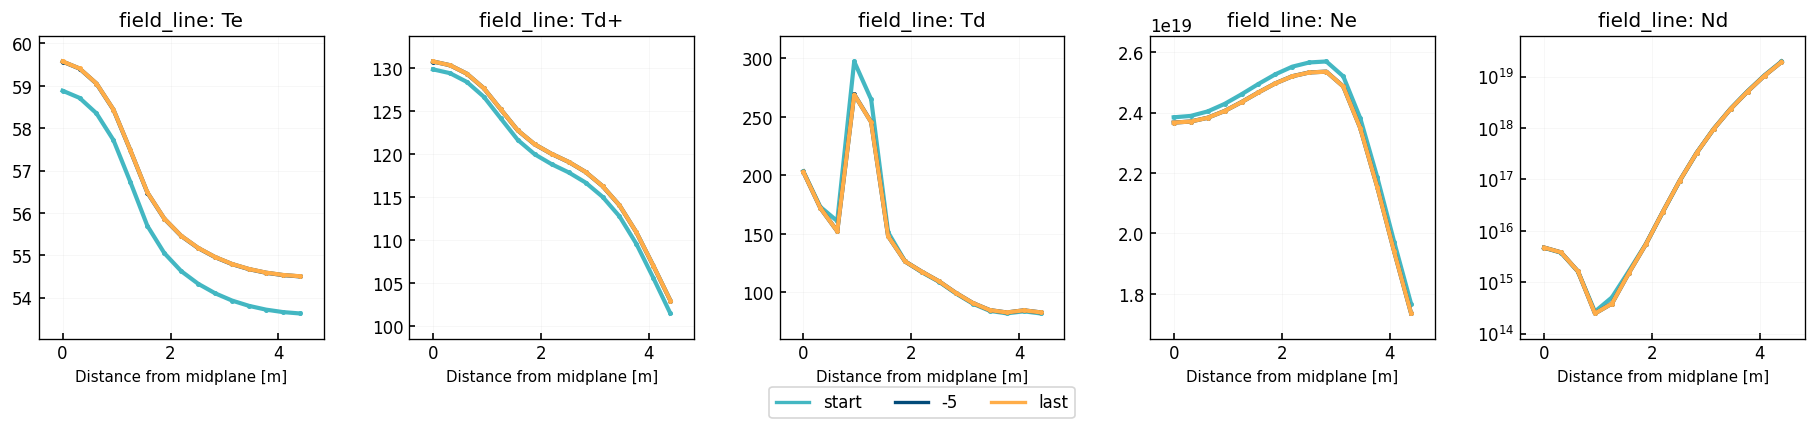

In [4]:
case = "base"
lineplot(
    {
        "start":cs[case].ds.isel(t=0, x = slice(2,-2)),
        "-5":cs[case].ds.isel(t=-3, x = slice(2,-2)),
        "last":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        # "base":cs["base"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    params = ["Te", "Td+", "Td", "Ne", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

# Case comparison

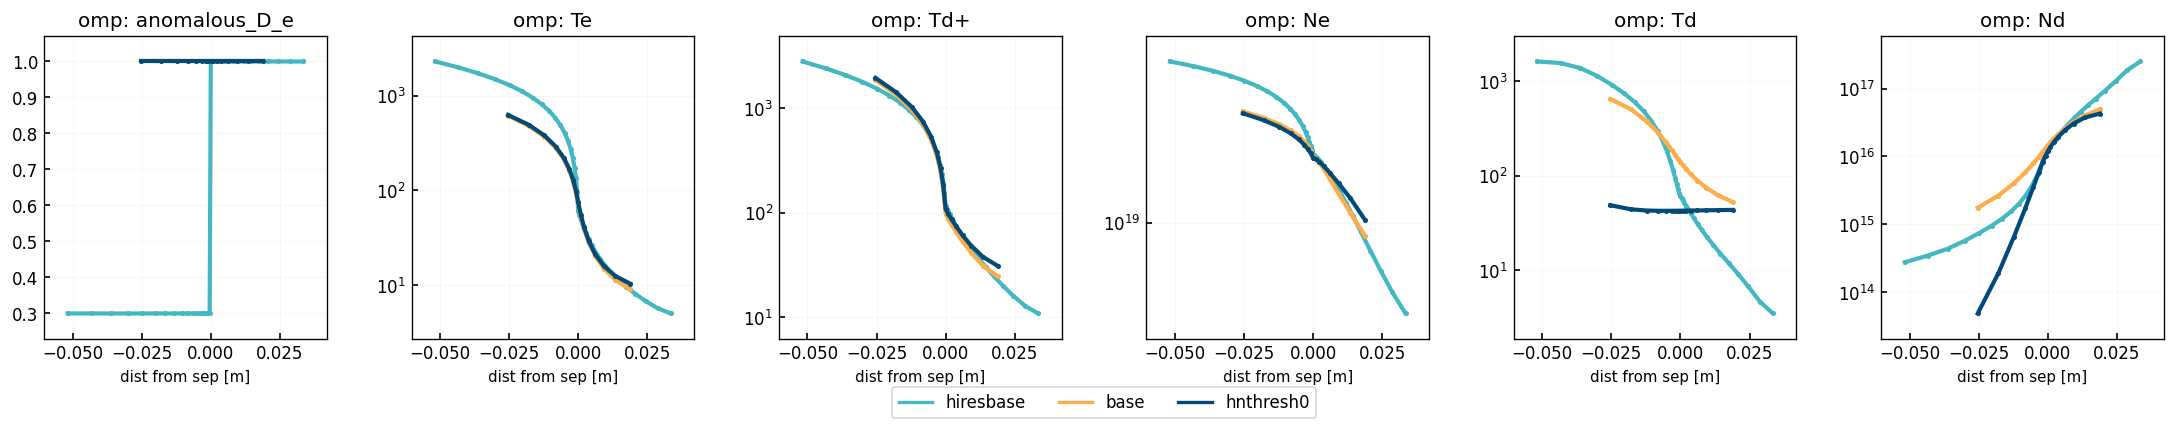

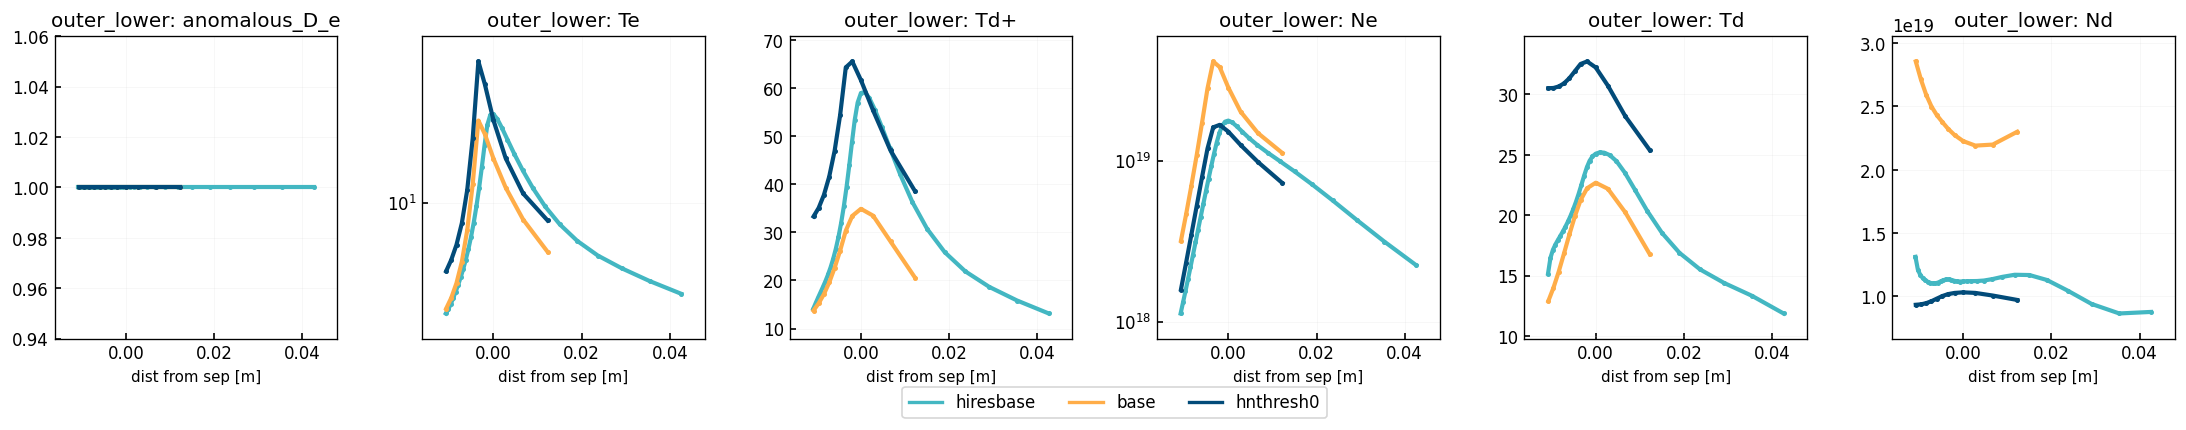

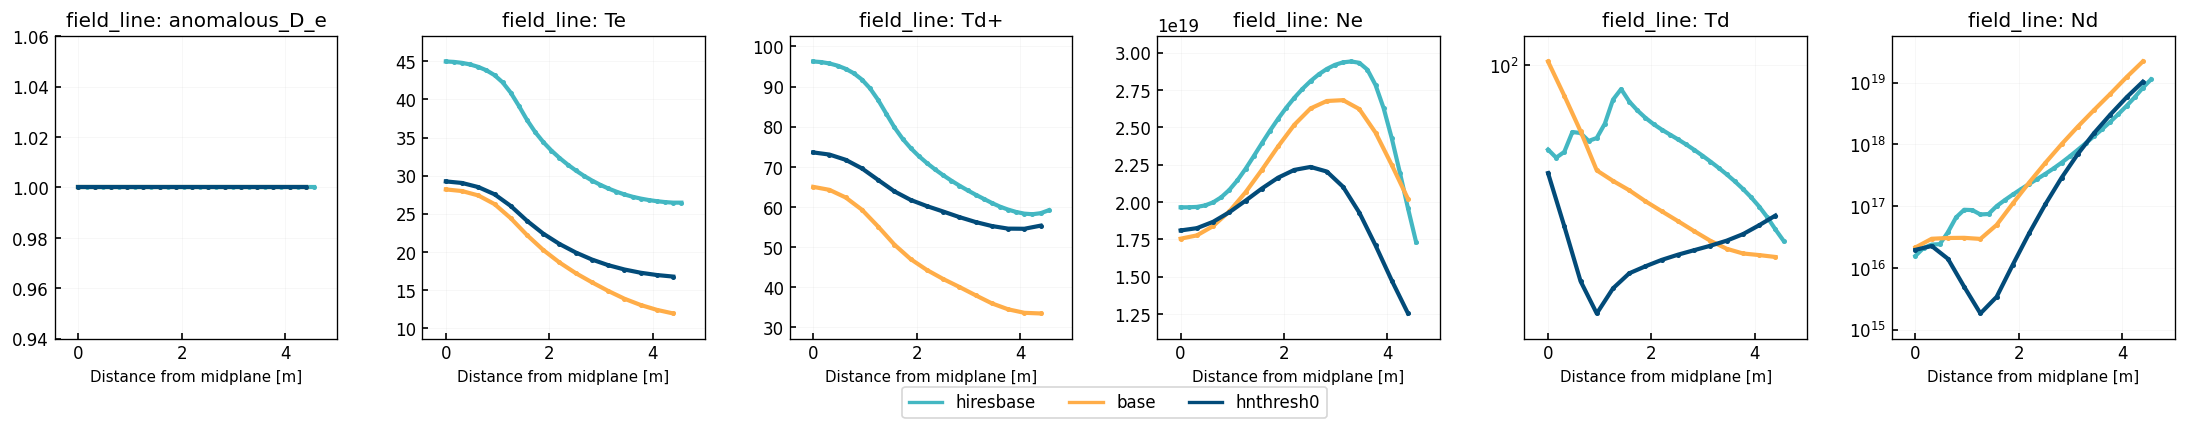

In [34]:
toplot = {}
for case in cs:
    toplot[case] = cs[case].ds.isel(t=-1, x = slice(2,-2))
    
lineplot(
    toplot,
    clean_guards = False,
    logscale = True,
    params = ["anomalous_D_e", "Te", "Td+", "Ne", "Td", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

# Detailed analysis

## Pick case

In [6]:
name = "hnthresh0"

## OMP - profiles

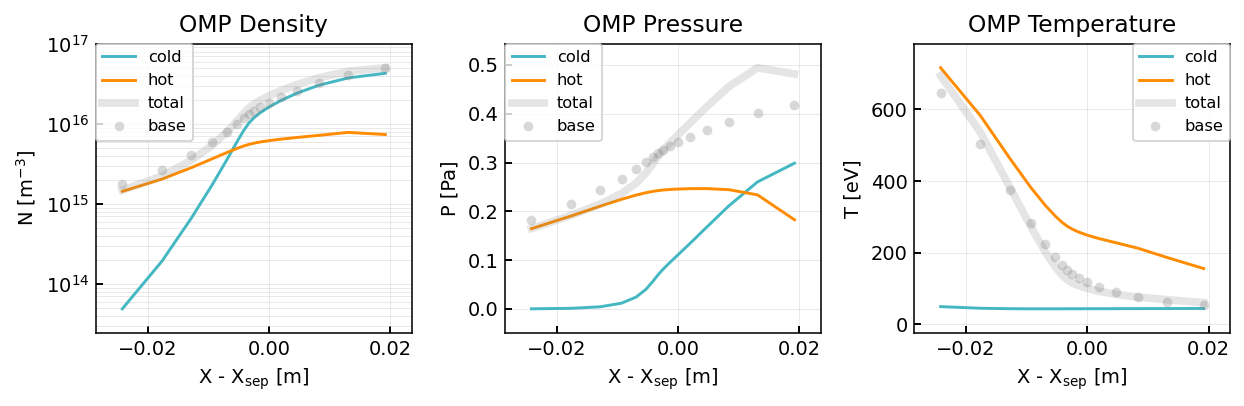

In [7]:
ds = cs[name].ds.isel(t=-1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2))
reg2 = cs["base"].ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2), t = -1)
title = "OMP"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 4, alpha = 0.2)
basekwargs = dict(c = "grey", lw = 0, marker = "o", ms = 5, alpha = 0.3, markeredgewidth = 0)

ax = axes[0]
ax.set_title("OMP Density")
ax.set_yscale("log")
ax.set_ylabel("N [$m^{-3}$]")
ax.plot(x, reg["Nd"], label = "cold", **kwargs)
ax.plot(x, reg["Nd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Nd"]+reg["Nd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Nd"], label = "base", **basekwargs)

ax = axes[1]
ax.set_title("OMP Pressure")
ax.set_ylabel("P [Pa]")
ax.plot(x, reg["Pd"], label = "cold", **kwargs)
ax.plot(x, reg["Pd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Pd"]+reg["Pd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Pd"], label = "base", **basekwargs)

ax = axes[2]
ax.set_title("OMP Temperature")
ax.set_ylabel("T [eV]")
ax.plot(x, reg["Td"], label = "cold", **kwargs)
ax.plot(x, reg["Td*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, (reg["Pd"]+reg["Pd*"])/(reg["Nd*"]+reg["Nd"])/constants("q_e"), label = "total", **totkwargs)
ax.plot(x, reg2["Td"], label = "base", **basekwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


## OMP - transport

In [9]:
for case in cs:
    cs[case].ds = calculate_radial_fluxes(cs[case].ds)

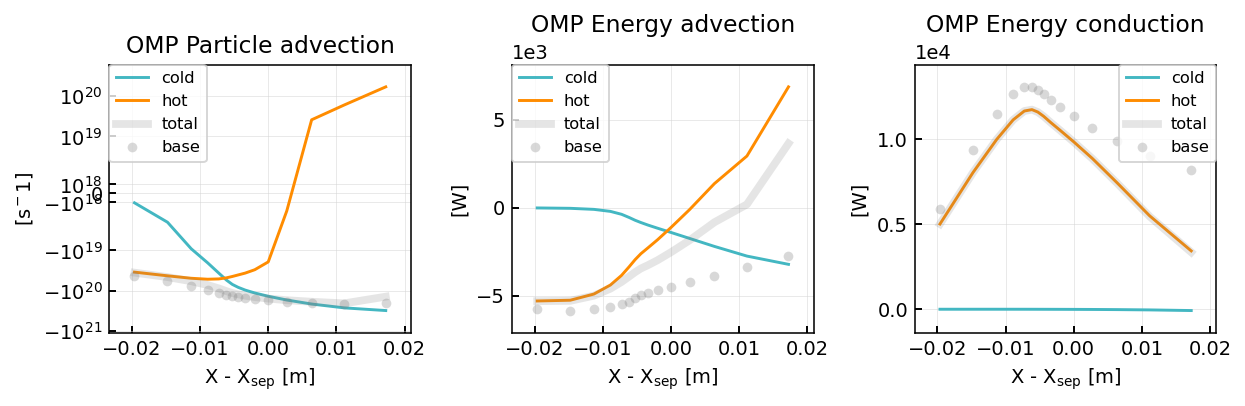

In [10]:
ds = cs[name].ds.isel(t=-1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(3,-2))
reg2 = cs["base"].ds.hermesm.select_region("outer_midplane_a").isel(x = slice(3,-2), t = -1)
title = "OMP"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 4, alpha = 0.2)
basekwargs = dict(c = "grey", lw = 0, marker = "o", ms = 5, alpha = 0.3, markeredgewidth = 0)

ax = axes[0]
ax.set_title("OMP Particle advection")
ax.set_yscale("symlog", linthresh = 5e18)
ax.set_ylabel("[$s^-1$]")
ax.plot(x, reg["pf_perp_diff_L_d"], label = "cold", **kwargs)
ax.plot(x, reg["pf_perp_diff_L_d*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["pf_perp_diff_L_d"]+reg["pf_perp_diff_L_d*"], label = "total", **totkwargs)
ax.plot(x, reg2["pf_perp_diff_L_d"], label = "base", **basekwargs)

ax = axes[1]
ax.set_title("OMP Energy advection")
ax.set_ylabel("[W]")
ax.plot(x, reg["hf_perp_conv_L_d"], label = "cold", **kwargs)
ax.plot(x, reg["hf_perp_conv_L_d*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["hf_perp_conv_L_d"]+reg["hf_perp_conv_L_d*"], label = "total", **totkwargs)
ax.plot(x, reg2["hf_perp_conv_L_d"], label = "base", **basekwargs)

ax = axes[2]
ax.set_title("OMP Energy conduction")
ax.set_ylabel("[W]")
ax.plot(x, reg["hf_perp_diff_L_d"], label = "cold", **kwargs)
ax.plot(x, reg["hf_perp_diff_L_d*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, (reg["hf_perp_diff_L_d"]+reg["hf_perp_diff_L_d*"]), label = "total", **totkwargs)
ax.plot(x, reg2["hf_perp_diff_L_d"], label = "base", **basekwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


## OMP - sources

In [ ]:
ds.data_vars

Text(0.5, 0, 'X - $X_{sep}$ [m]')

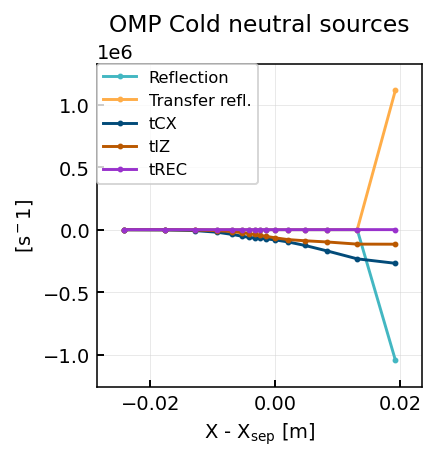

In [22]:
ds = cs[name].ds.isel(t=-1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2)).squeeze()

fig, ax = plt.subplots(1, figsize = (3,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 2)

ax.set_title("OMP Cold neutral sources")
# ax.set_yscale("symlog", linthresh = 5e18)
ax.set_ylabel("[$s^-1$]")
ax.plot(x, reg["Ed_wall_refl"], label = "Reflection", **kwargs)
ax.plot(x, reg["Edd*_wall_refl"], label = "Transfer refl.", **kwargs)
# ax.plot(x, reg["Edd+_cx"], label = "CX", **kwargs)
ax.plot(x, reg["Edd+_cxt"], label = "tCX", **kwargs)
ax.plot(x, reg["Edd+_iz"]*-1, label = "tIZ", **kwargs)
ax.plot(x, reg["Ed+_rec"]*-1, label = "tREC", **kwargs)

ax.legend(fontsize = "small")
ax.set_xlabel("X - $X_{sep}$ [m]")



## 2D sources

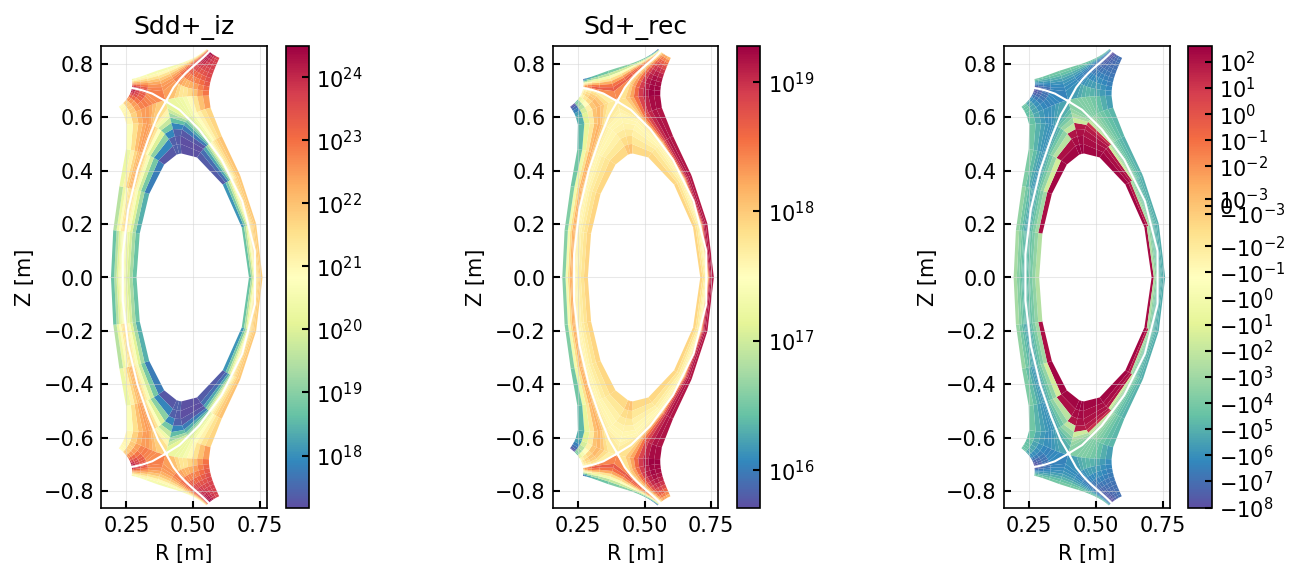

In [38]:
# dSrcTot = ds["Ed_wall_refl"] + ds["Edd*_wall_refl"] + ds["Edd+_cxt"] + ds["Edd+_iz"]*-1 + ds["Ed+_rec"] * -1
dSrcTot = ds["Edd+_iz"]*-1 + ds["Ed+_rec"] * -1

fig, axes = plt.subplots(1,3, dpi = 150, figsize = (11,4))

(ds["Sdd+_iz"]).hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", antialias = True, 
                                                            vmin = None, vmax = None, 
                                                            logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

(ds["Sd+_rec"] * -1).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", antialias = True, 
                                                            vmin = None, vmax = None, 
                                                            logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

(ds["Edd+_iz"]*-1 + ds["Ed+_rec"] * -1).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "Spectral_r", antialias = True, 
                                                            vmin = None, vmax = None, 
                                                            logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

## Target - profiles

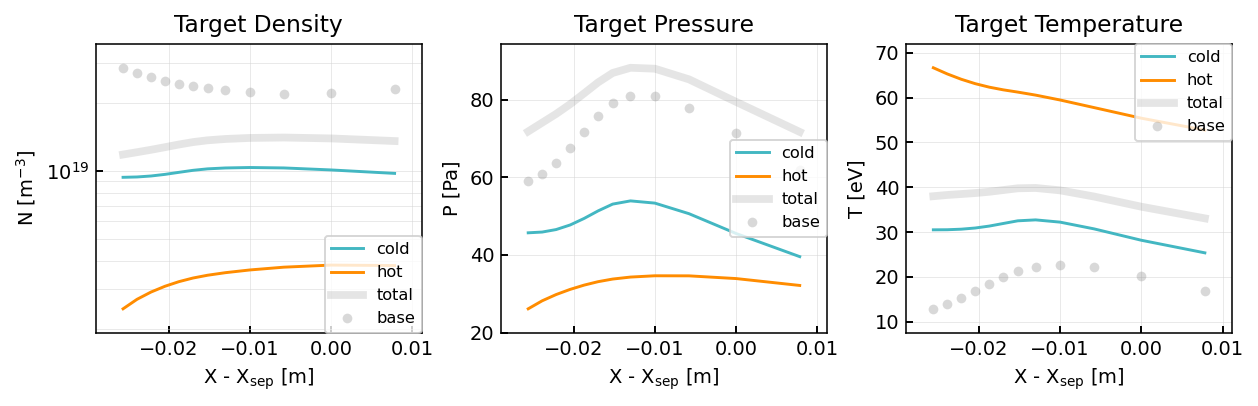

In [32]:
ds = cs[name].ds.isel(t=-1)
reg = ds.hermesm.select_region("outer_lower_target").isel(x = slice(2,-2))
reg2 = cs["base"].ds.hermesm.select_region("outer_lower_target").isel(x = slice(2,-2), t = -1)
title = "Target"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 4, alpha = 0.2)
basekwargs = dict(c = "grey", lw = 0, marker = "o", ms = 5, alpha = 0.3, markeredgewidth = 0)

ax = axes[0]
ax.set_title(f"{title} Density")
ax.set_yscale("log")
ax.set_ylabel("N [$m^{-3}$]")
ax.plot(x, reg["Nd"], label = "cold", **kwargs)
ax.plot(x, reg["Nd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Nd"]+reg["Nd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Nd"], label = "base", **basekwargs)

ax = axes[1]
ax.set_title(f"{title} Pressure")
ax.set_ylabel("P [Pa]")
ax.plot(x, reg["Pd"], label = "cold", **kwargs)
ax.plot(x, reg["Pd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Pd"]+reg["Pd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Pd"], label = "base", **basekwargs)

ax = axes[2]
ax.set_title(f"{title} Temperature")
ax.set_ylabel("T [eV]")
ax.plot(x, reg["Td"], label = "cold", **kwargs)
ax.plot(x, reg["Td*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, (reg["Pd"]+reg["Pd*"])/(reg["Nd*"]+reg["Nd"])/constants("q_e"), label = "total", **totkwargs)
ax.plot(x, reg2["Td"], label = "base", **basekwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


In [20]:
izrate = np.array([
    [-32.4802533034, -0.05440669186583, 0.09048888225109, -0.04054078993576,
     0.008976513750477, -0.001060334011186, 6.846238436472e-05, -2.242955329604e-06,
     2.890437688072e-08],
    [14.2533239151, -0.0359434716076, -0.02014729121556, 0.0103977361573,
     -0.001771792153042, 0.0001237467264294, -3.130184159149e-06, -3.051994601527e-08,
     1.888148175469e-09],
    [-6.632235026785, 0.09255558353174, -0.005580210154625, -0.005902218748238,
     0.001295609806553, -0.0001056721622588, 4.646310029498e-06, -1.479612391848e-07,
     2.85225125832e-09],
    [2.059544135448, -0.07562462086943, 0.01519595967433, 0.0005803498098354,
     -0.0003527285012725, 3.201533740322e-05, -1.835196889733e-06, 9.474014343303e-08,
     -2.342505583774e-09],
    [-0.442537033141, 0.02882634019199, -0.00728577148505, 0.0004643389885987,
     1.145700685235e-06, 8.493662724988e-07, -1.001032516512e-08, -1.476839184318e-08,
     6.047700368169e-10],
    [0.06309381861496, -0.00578868653578, 0.00150738295525, -0.0001201550548662,
     6.574487543511e-06, -9.678782818849e-07, 5.176265845225e-08, 1.29155167686e-09,
     -9.685157340473e-11],
    [-0.005620091829261, 0.000632910556804, -0.0001527777697951, 8.270124691336e-06,
     3.224101773605e-08, 4.377402649057e-08, -2.622921686955e-09, -2.259663431436e-10,
     1.161438990709e-11],
    [0.0002812016578355, -3.564132950345e-05, 7.222726811078e-06, 1.433018694347e-07,
     -1.097431215601e-07, 7.789031791949e-09, -4.197728680251e-10, 3.032260338723e-11,
     -8.911076930014e-13],
    [-6.011143453374e-06, 8.089651265488e-07, -1.186212683668e-07, -2.381080756307e-08,
     6.271173694534e-09, -5.48301024493e-10, 3.064611702159e-11, -1.355903284487e-12,
     2.935080031599e-14]
    ])

recrate = np.array([
    [-28.58858570847, 0.02068671746773, -0.007868331504755, 0.003843362133859,
     -0.0007411492158905, 9.273687892997e-05, -7.063529824805e-06, 3.026539277057e-07,
     -5.373940838104e-09],
    [-0.7676413320499, 0.0127800603259, -0.01870326896978, 0.00382855504889,
     -0.0003627770385335, 4.401007253801e-07, 1.932701779173e-06, -1.176872895577e-07,
     2.215851843121e-09],
    [0.002823851790251, -0.001907812518731, 0.01121251125171, -0.003711328186517,
     0.0006617485083301, -6.860774445002e-05, 4.508046989099e-06, -1.723423509284e-07,
     2.805361431741e-09],
    [-0.01062884273731, -0.01010719783828, 0.004208412930611, -0.00100574441054,
     0.0001013652422369, -2.044691594727e-06, -4.431181498017e-07, 3.457903389784e-08,
     -7.374639775683e-10],
    [0.001582701550903, 0.002794099401979, -0.002024796037098, 0.0006250304936976,
     -9.224891301052e-05, 7.546853961575e-06, -3.682709551169e-07, 1.035928615391e-08,
     -1.325312585168e-10],
    [-0.0001938012790522, 0.0002148453735781, 3.393285358049e-05, -3.746423753955e-05,
     7.509176112468e-06, -8.688365258514e-07, 7.144767938783e-08, -3.367897014044e-09,
     6.250111099227e-11],
    [6.041794354114e-06, -0.0001421502819671, 6.14387907608e-05, -1.232549226121e-05,
     1.394562183496e-06, -6.434833988001e-08, -2.746804724917e-09, 3.564291012995e-10,
     -8.55170819761e-12],
    [1.742316850715e-06, 1.595051038326e-05, -7.858419208668e-06, 1.774935420144e-06,
     -2.187584251561e-07, 1.327090702659e-08, -1.386720240985e-10, -1.946206688519e-11,
     5.745422385081e-13],
    [-1.384927774988e-07, -5.664673433879e-07, 2.886857762387e-07, -6.591743182569e-08,
     8.008790343319e-09, -4.805837071646e-10, 6.459706573699e-12, 5.510729582791e-13,
     -1.680871303639e-14]
])

from sd1d.analysis import AMJUEL



In [21]:
cs.keys()



dict_keys(['base', 'hnthresh0'])

*****************************
Excel saves precision as it appears, not as what the number has.......
*****************************


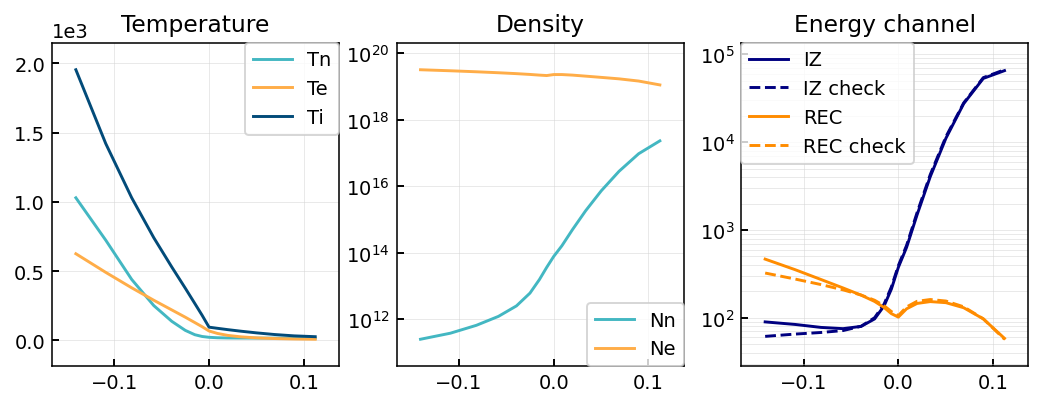

In [27]:
ds = cs["hnthresh0"].ds.isel(t=-1)

reg = ds.isel(x = slice(2,-2), theta = 45)   # Radial slice above X-point
# reg = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))           # OMP

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = reg["dr"].cumsum()
x -= x[ds.metadata["ixseps1"] - ds.metadata["MXG"]]

Te = reg["Te"].values
Ne = reg["Ne"].values

amj = AMJUEL()
Krec = amj.amjuel_2d("rec", Te, Ne, data = recrate)
Kiz = amj.amjuel_2d("rec", Te, Ne, data = izrate)

ax = axes[0]
ax.set_title("Temperature")
ax.plot(x, reg["Td"], label = "Tn")
ax.plot(x, reg["Te"], label = "Te")
ax.plot(x, reg["Td+"], label = "Ti")
ax.legend()

# ax = axes[0,1]
# ax.set_title("Density channel")
# ax.set_yscale("log")
# ax.plot(x, reg["Sdd+_iz"], c = "navy", label = "IZ")
# ax.plot(x, Kiz * reg["Ne"] * reg["Nd"], c = "navy", ls = "--", label = "IZ check")
# ax.plot(x, reg["Sd+_rec"]*-1, c = "darkorange", label = "REC")
# ax.plot(x, Krec * reg["Ne"]**2, c = "darkorange", ls = "--", label = "REC check")
# ax.legend()

ax = axes[1]
ax.set_title("Density")
ax.set_yscale("log")
ax.plot(x, reg["Nd"], label = "Nn")
ax.plot(x, reg["Ne"], label = "Ne")
ax.legend()

ax = axes[2]
ax.set_title("Energy channel")
ax.set_yscale("log")
ax.plot(x, reg["Edd+_iz"], c = "navy", label = "IZ")
ax.plot(x, Kiz * reg["Ne"] * reg["Nd"] * reg["Td"] * (3/2) * constants("q_e"), c = "navy", ls = "--", label = "IZ check")
ax.plot(x, reg["Ed+_rec"]*-1, c = "darkorange", label = "REC")
ax.plot(x, Krec * reg["Ne"]**2 * reg["Td+"] * (3/2) * constants("q_e"), c = "darkorange", ls = "--", label = "REC check")
ax.legend()

## FIeld line

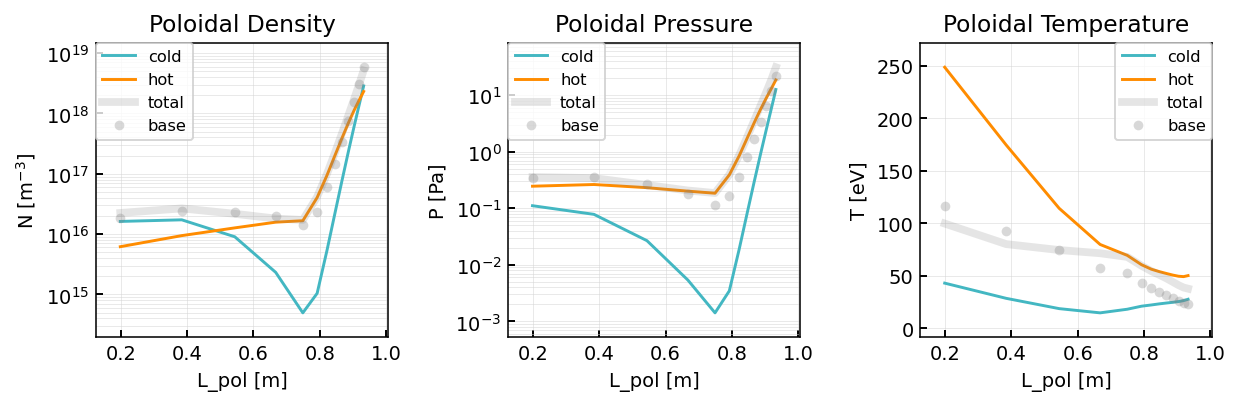

In [11]:
ds = cs[name].ds
reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").isel(theta = slice(None,-2), t = -1).squeeze()
reg2 = cs["base"].ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").isel(theta = slice(None,-2), t = -1).squeeze()
title = "Field line"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dl"]).values

kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 4, alpha = 0.2)
basekwargs = dict(c = "grey", lw = 0, marker = "o", ms = 5, alpha = 0.3, markeredgewidth = 0)

ax = axes[0]
ax.set_title("Poloidal Density")
ax.set_yscale("log")
ax.set_ylabel("N [$m^{-3}$]")
ax.plot(x, reg["Nd"], label = "cold", **kwargs)
ax.plot(x, reg["Nd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Nd"]+reg["Nd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Nd"], label = "base", **basekwargs)

ax = axes[1]
ax.set_title("Poloidal Pressure")
ax.set_yscale("log")
ax.set_ylabel("P [Pa]")
ax.plot(x, reg["Pd"], label = "cold", **kwargs)
ax.plot(x, reg["Pd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Pd"]+reg["Pd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Pd"], label = "base", **basekwargs)

ax = axes[2]
ax.set_title("Poloidal Temperature")
ax.set_ylabel("T [eV]")
ax.plot(x, reg["Td"], label = "cold", **kwargs)
ax.plot(x, reg["Td*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, (reg["Pd"]+reg["Pd*"])/(reg["Nd*"]+reg["Nd"])/constants("q_e"), label = "total", **totkwargs)
ax.plot(x, reg2["Td"], label = "base", **basekwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("L_pol [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


# 2D plots

## Hot neutral diags

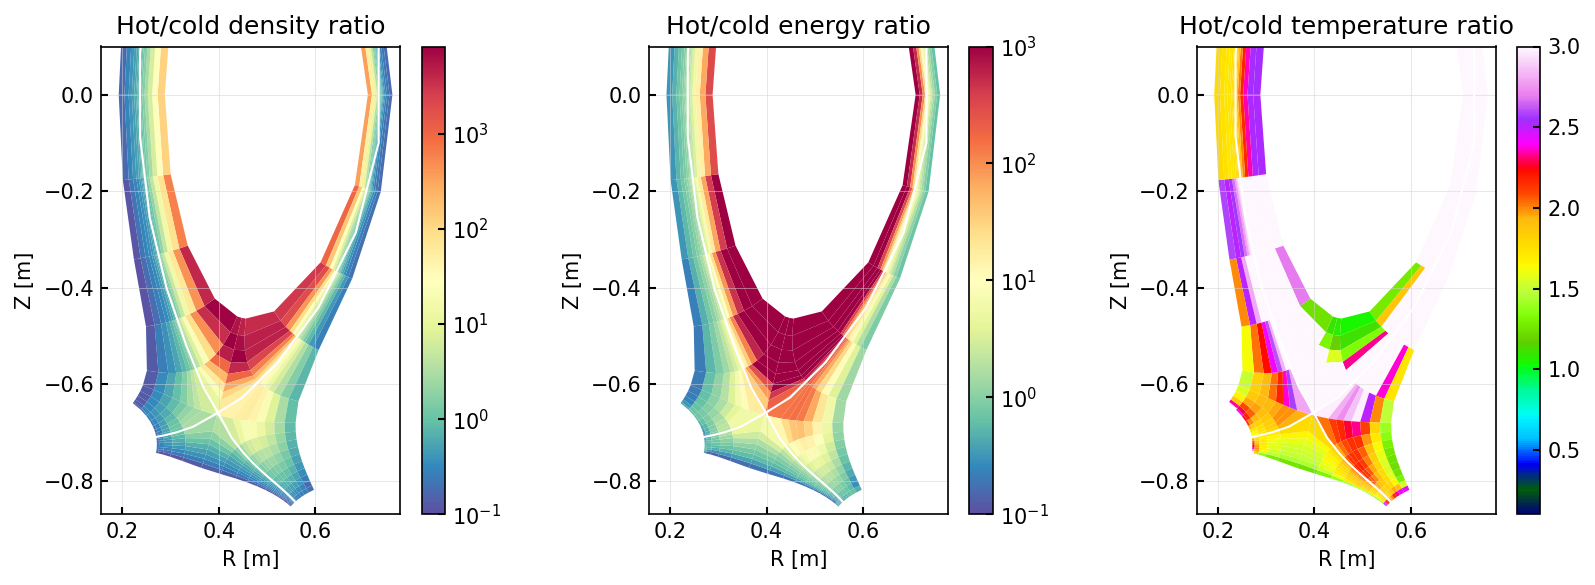

In [18]:
fig, axes = plt.subplots(1,3, dpi = 150, figsize = (11,4))

ds = cs["hnthresh0"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)
sepkwargs = dict(linewidth = 1, color = "white", linestyle = "-")
(ds["Nd*"] / ds["Nd"]).hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", antialias = True, 
                                                            vmin = 0.1, vmax = None, logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

(ds["Pd*"] / ds["Pd"]).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", antialias = True,
                                                           vmin = 0.1, vmax = 1000, logscale = True, 
                                                           separatrix_kwargs = sepkwargs, targets = False)

(ds["Td*"] / ds["Td"]).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", antialias = True, 
                                                            vmin = 0.1, vmax = 3, logscale = False, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

axes[0].set_title("Hot/cold density ratio")
axes[1].set_title("Hot/cold energy ratio")
axes[2].set_title("Hot/cold temperature ratio")

for ax in axes:
    ax.set_ylim(-0.87,0.1)
    
fig.tight_layout()

## Fields

In [42]:
entry.keys()

dict_keys(['name', 'id', 'unnormalise_geom', 'use_xhermes', 'squash'])

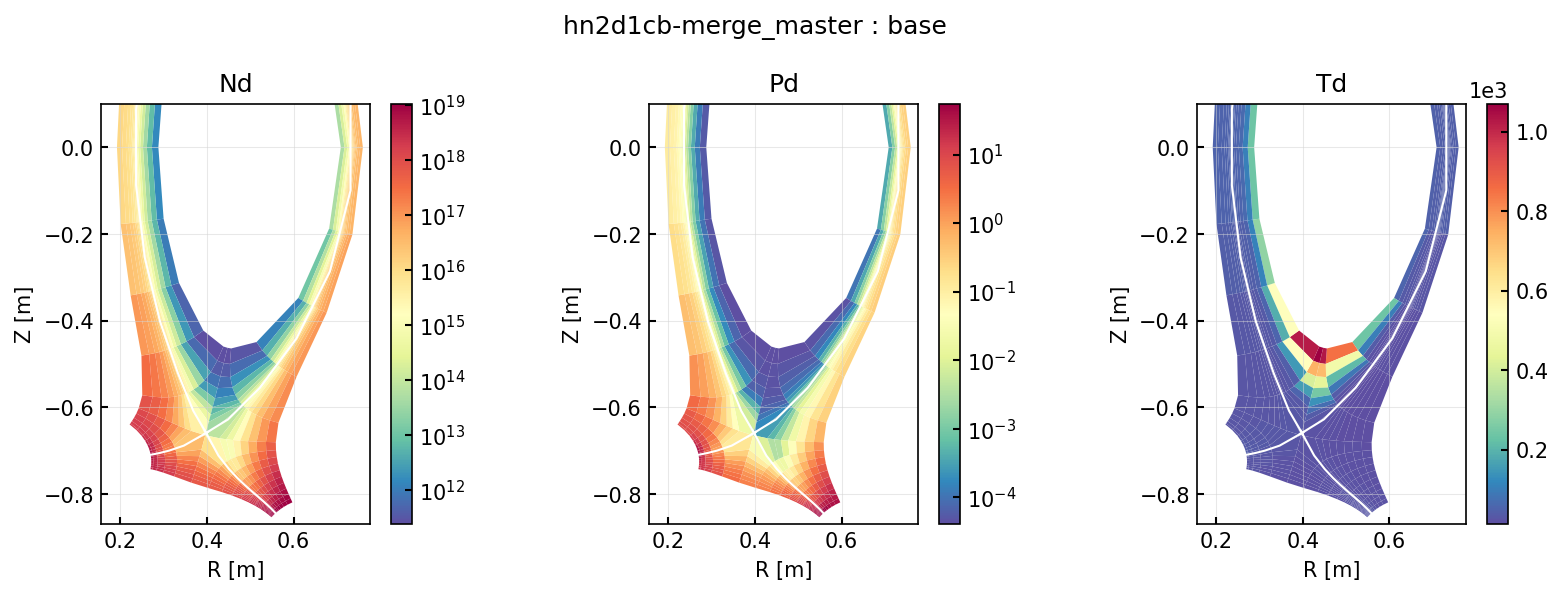

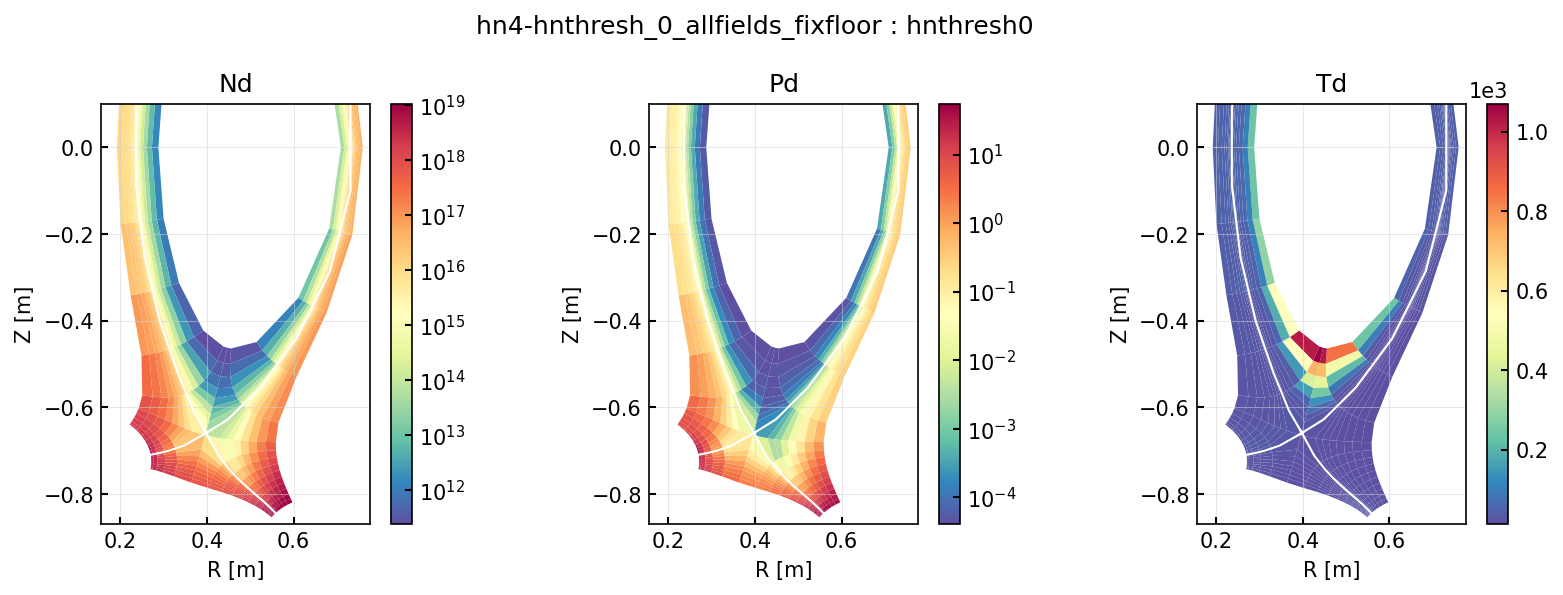

In [19]:

for entry in toload:
    case = entry["name"]
    fig, axes = plt.subplots(1,3, dpi = 150, figsize = (11,4))
    newds = cs[case].ds.isel(t=-1)
    
    if "t" in ds.dims: ds = ds.isel(t=-1)
    sepkwargs = dict(linewidth = 1, color = "white", linestyle = "-")
    (ds["Nd"]).hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", antialias = True, 
                                                                vmin = None, vmax = None, logscale = True, 
                                                                separatrix_kwargs = sepkwargs, targets = False)

    (ds["Pd"]).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", antialias = True,
                                                            vmin = None, vmax = None, logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

    (ds["Td"]).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "Spectral_r", antialias = True, 
                                                                vmin = None, vmax = None, logscale = False, 
                                                                separatrix_kwargs = sepkwargs, targets = False)

    # axes[0].set_title("Hot/cold density ratio")
    # axes[1].set_title("Hot/cold energy ratio")
    # axes[2].set_title("Hot/cold temperature ratio")

    for ax in axes:
        ax.set_ylim(-0.87,0.1)
        
    fig.suptitle(f"{entry['id']} : {case}")
    fig.tight_layout()

# Floor check

In [17]:
# ds = cs["newalldisabled_lopnfloor"].ds.isel(t=-1)
for case in cs:
    ds = cs[case].ds.isel(t=-1)
    # cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["darkorange", "white", "navy"], N=3)
    cmap = "PuOr"

    floors = ds.hermesm.get_floors()
    nn_floor_si = floors["nn_floor_si"]
    pn_floor_si = floors["pn_floor_si"]
    
    nn_breached = (ds["Nd"].values < floors["nn_floor_si"]).any()
    pn_breached = (ds["Pd"].values < floors["pn_floor_si"]).any()
    
    print(f"{case}: Nn floor breached: {nn_breached}, Pn floor breached: {pn_breached}")
    

    # fig, ax = plt.subplots(dpi = 150)
    # (ds["Nd"]).bout.polygon(ax = ax, cmap = cmap, targets = False, 
    #                                                     separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 0),
    #                                                     antialias = True,
    #                                                     logscale = True,
    #                                                     vmin = nn_floor_si*1e-1,
    #                                                     vmax = nn_floor_si*1e1)
    # # ax.set_ylim(-0.9, 0)

    # fig, ax = plt.subplots(dpi = 150)
    # data = ds["Pd"]/ds["Pd"].attrs["conversion"]
    # data.bout.polygon(ax = ax, cmap = cmap, targets = False, 
    #                                                     separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 0),
    #                                                     antialias = True,
    #                                                     logscale = True,
    #                                                     vmin = floors["pn_floor"]*1e-1,
    #                                                     vmax = floors["pn_floor"]*1e1)
    # ax.set_ylim(-0.9, 0)

base: Nn floor breached: False, Pn floor breached: False
hnthresh0: Nn floor breached: False, Pn floor breached: False
